In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import plot_tree

### Data Preprocessing

In [2]:
bus_data = pd.read_csv('bus_cleaned.csv')
print(bus_data.head())

weather_data = pd.read_csv('Toronto_2014-2020WeatherData.csv')
print(weather_data.head())


         date  route_num   exact_time day_of_week              location  \
0  2014-01-01         95  12:23:00 AM   Wednesday    YORK MILLS STATION   
1  2014-01-01        102  12:55:00 AM   Wednesday  ENTIRE RUN FOR ROUTE   
2  2014-01-01         54   1:28:00 AM   Wednesday   LAWRENCE AND WARDEN   
3  2014-01-01        112   1:30:00 AM   Wednesday       KIPLING STATION   
4  2014-01-01         24   1:37:00 AM   Wednesday      VP AND ELLESMERE   

             incident  delay_min  gap_min direction  vehicle  year  month  \
0          Mechanical         10     20.0         E   1734.0  2014      1   
1       General Delay         33     66.0       b/w   8110.0  2014      1   
2          Mechanical         10     20.0        WB   7478.0  2014      1   
3  Emergency Services         18     36.0         N   8084.0  2014      1   
4       Investigation         10     20.0         n   7843.0  2014      1   

   day  hour  min  at_station delay_type direction_simp  
0    1     0   23           

In [3]:
#remove unnessary columns 
bus_data = bus_data[['date', 'route_num', 'incident', 'delay_min']]  
weather_data = weather_data[['datetime', 'temp', 'precip', 'preciptype', 'snow']]

#remove uncorrelated delay types
unwanted_incidents = ["Emergency Services", "Investigation", "Utilized Off Route", "Management", "Late Leaving Garage - Management"]
bus_data = bus_data[~bus_data['incident'].isin(unwanted_incidents)]

#rename columns to match before merging
weather_data = weather_data.rename(columns={'datetime': 'date', 'precip': 'precip_mm', 'snow': 'snow_cm'})

In [4]:

# Create the 'preciptype_rain' and 'preciptype_snow' columns
weather_data['preciptype_rain'] = weather_data['preciptype'].apply(lambda x: 1 if 'rain' in str(x).lower() else 0)
weather_data['preciptype_snow'] = weather_data['preciptype'].apply(lambda x: 1 if 'snow' in str(x).lower() else 0)
# Drop the 'preciptype' column
weather_data = weather_data.drop(columns=['preciptype'])

# Merge the bus_data and weather_data on the 'date' column
merged_data = pd.merge(bus_data, weather_data, on='date', how='inner')

print(merged_data.head())

         date  route_num       incident  delay_min  temp  precip_mm  snow_cm  \
0  2014-01-01         95     Mechanical         10 -11.0        0.0      0.6   
1  2014-01-01        102  General Delay         33 -11.0        0.0      0.6   
2  2014-01-01         54     Mechanical         10 -11.0        0.0      0.6   
3  2014-01-01        129     Mechanical         10 -11.0        0.0      0.6   
4  2014-01-01         36     Mechanical         16 -11.0        0.0      0.6   

   preciptype_rain  preciptype_snow  
0                0                1  
1                0                1  
2                0                1  
3                0                1  
4                0                1  


In [5]:
# Assuming merged_data is already your merged dataset

# Perform one-hot encoding for the 'incident' column
incident_dummies = pd.get_dummies(merged_data['incident'], prefix='incident')

# Merge the one-hot encoded columns back into the original dataframe
merged_data = pd.concat([merged_data, incident_dummies], axis=1)

# Drop the original 'incident' column since it's now encoded
merged_data = merged_data.drop(columns=['incident'])

# Verify the result
print(merged_data.head())


         date  route_num  delay_min  temp  precip_mm  snow_cm  \
0  2014-01-01         95         10 -11.0        0.0      0.6   
1  2014-01-01        102         33 -11.0        0.0      0.6   
2  2014-01-01         54         10 -11.0        0.0      0.6   
3  2014-01-01        129         10 -11.0        0.0      0.6   
4  2014-01-01         36         16 -11.0        0.0      0.6   

   preciptype_rain  preciptype_snow  incident_Diversion  \
0                0                1               False   
1                0                1               False   
2                0                1               False   
3                0                1               False   
4                0                1               False   

   incident_General Delay  incident_Late Leaving Garage  \
0                   False                         False   
1                    True                         False   
2                   False                         False   
3                 

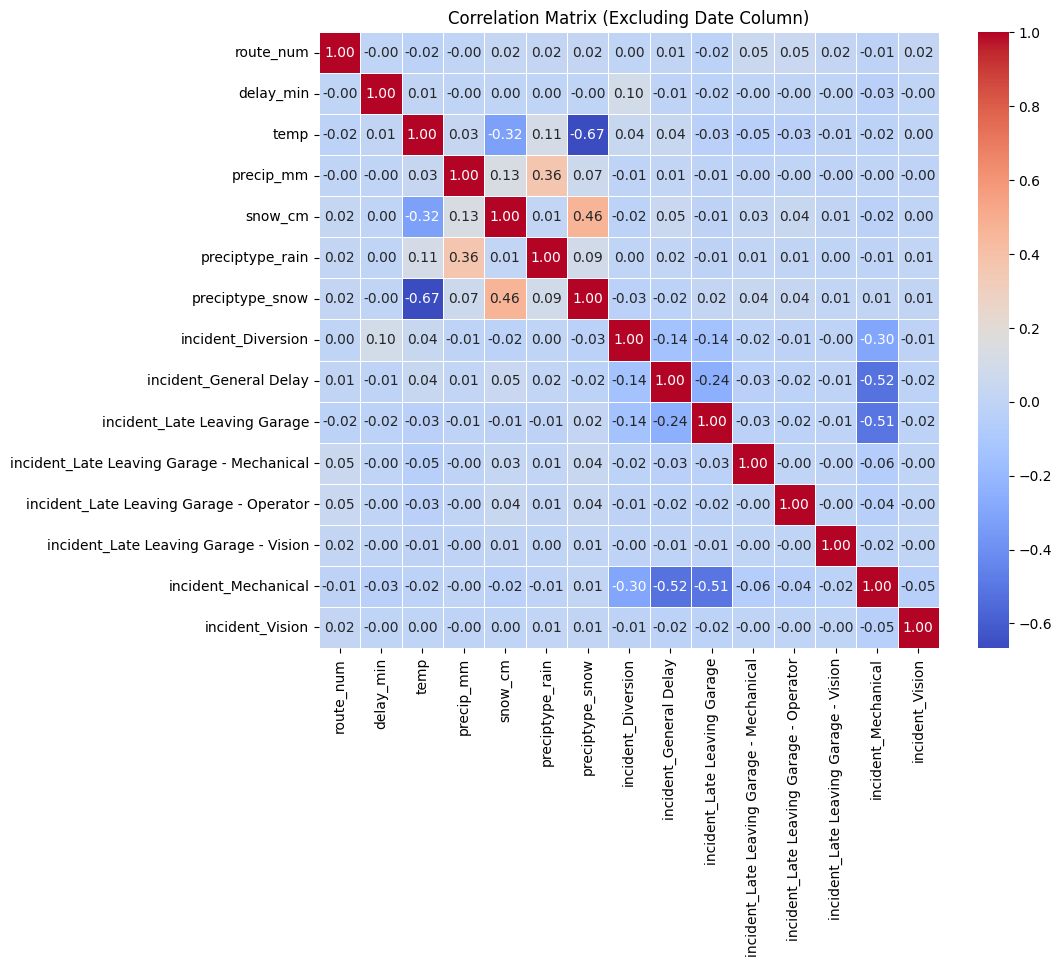

In [90]:
# Drop the 'date' column and any other non-numeric columns
data_for_correlation = merged_data.drop(columns=['date'])

# Calculate the correlation matrix
correlation_matrix = data_for_correlation.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Excluding Date Column)')
plt.show()

### Regression Analysis - Decision Trees

Decision Tree is used to capture non-linear patterns

In [82]:
# Define features (X) and target variable (y)
X_data = merged_data[['preciptype_rain', 'preciptype_snow', 'temp', 'precip_mm', 'snow_cm']]  # Select weather-related features
y_data = merged_data['delay_min']  # Target variable: delay in minutes

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Check the shape of the train and test sets
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training data shape: X_train=(253779, 5), y_train=(253779,)
Testing data shape: X_test=(63445, 5), y_test=(63445,)


In [85]:
# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

from sklearn.metrics import mean_absolute_error, r2_score

# Calculate R² (R-squared)
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = (abs(y_test - y_pred) / y_test).mean() * 100

# Print the results
print(f'R-squared: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')


Mean Absolute Error: 28.06
R-squared: -9.493442779229255e-06
Mean Absolute Error (MAE): 28.061400751075077
Mean Absolute Percentage Error (MAPE): 161.9850513055231
